In [1]:
from popsims.evol_models import EVOL_MODELS
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import griddata
from numba import njit


import numpy as np
import pandas as pd
from popsims import fast_2d_interpolation
%matplotlib inline

In [2]:
df_roman=pd.read_csv('/users/caganze/research/roman_new_isochrones.csv')

In [3]:
df_roman=df_roman.rename(columns={'teff': 'temperature', 
                                 'lum': 'luminosity'})

In [4]:
df_roman['age']=df_roman.age/1e9

In [5]:
class EvolutionaryModel:
    def __init__(self,  dataframe):
        #initialize model 
        req_columns=['mass', 'age']
        assert all(column in dataframe.columns for column in req_columns), "DataFrame is missing required columns"
        self.columns=np.array(dataframe.columns)
        self.data = dataframe[self.columns].values

    def interpolate(self, x_axis, y_axis, x_values, y_values, \
                    logscale=['mass', 'age', 'temperature'], interp_columns=['temperature']):
        
        assert x_axis in self.columns, f"x_axis '{x_axis}' not found in DataFrame columns"
        assert y_axis in self.columns, f"y_axis '{y_axis}' not found in DataFrame columns"
        
        #make a copy of data 
        #put stuff on logscale
        dt= self.data.copy()
        for c in logscale:
            col_idx = np.where(self.columns == c)[0][0]
            dt[:, col_idx] =np.log10(np.array(dt[:, col_idx]).astype(float))
            
        points = dt[:, [np.where(self.columns == x_axis)[0][0], np.where(self.columns == y_axis)[0][0]]]
        remaining_columns = [col for col in interp_columns if col not in [x_axis, y_axis]]
        results = {}
        
        for col in remaining_columns:
            col_idx = np.where(self.columns == col)[0][0]
            values =dt[:, col_idx]
            #result = np.empty_like(y_values)
            #interp_values= interpolate_2d(points, values, x_values, y_values, result)
            results[col] = fast_2d_interpolation(points, values, x_values, y_values)
            
        interp_df= pd.DataFrame(results)
        interp_df[x_axis]=x_values
        interp_df[y_axis]=y_values
        return interp_df

In [6]:
from popsims.evol_models import EVOL_MODELS

In [7]:
#df=

In [8]:
EVOL_MODELS['marley2019'].keys()

dict_keys(['mass', 'age', 'luminosity', 'temperature', 'gravity', 'radius'])

In [9]:
#df=pd.DataFrame(EVOL_MODELS['burrows1997'])
df=df_roman
m= EvolutionaryModel(df)
mass=np.random.uniform(-2, 1, 100000)
age=np.random.uniform(-2.5, 1., 100000)
res=m.interpolate('mass','age', mass, age)

In [10]:
df.columns

Index(['mass', 'temperature', 'radius', 'logg', 'luminosity', 'bol_mag',
       'tau_100_temp', 'tau_100_pgas', 'photosphere_temp', 'EBV',
       ...
       'Euclid_NISP0.H', 'WFIRST_WFI.H158', 'Paranal_VISTA.H',
       'PAN-STARRS_PS1.y', 'Subaru_HSC.g', 'JWST_NIRISS.F277W', 'LSST_LSST.z',
       'PAN-STARRS_PS1.i', 'Fe_H', 'age'],
      dtype='object', length=107)

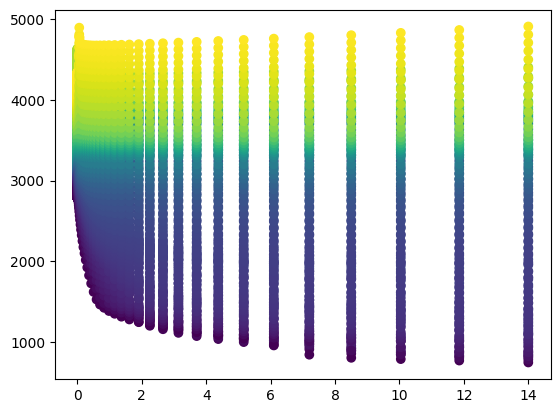

In [11]:
fig, ax=plt.subplots()
c=ax.scatter(df.age, df.temperature, c=np.log10(df.mass))

In [12]:
#plt.hist(10**age)

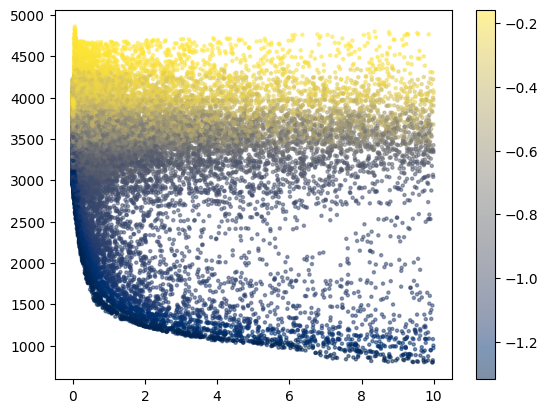

In [13]:
fig, ax=plt.subplots()
c=ax.scatter(10**age, 10**res.temperature.values,  c=mass, s=5, alpha=0.5, cmap='cividis')

plt.colorbar(c)

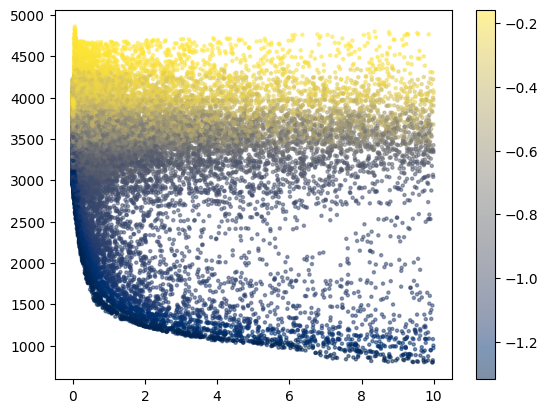

In [14]:
res=m.interpolate('mass','age', mass, age)
fig, ax=plt.subplots()
c=ax.scatter(10**age, 10**res.temperature.values,  c=mass,  s=5,alpha=0.5, cmap='cividis')

plt.colorbar(c)

In [15]:
def interpolate_evolutionary_model(Model, mass, age, additional_columns=[]):
    #first remove nans
    lmass=mass
    lage=age


    res=Model.interpolate('mass','age', lmass, lage, logscale=['mass', 'age', 'temperature'])
    #return evolutionary_model_interpolator(mass, age, self.evolmodel)
    res['mass']=10**lmass
    res['age']=10**lage
    res['temperature']=10**res.temperature.values
    return res


In [16]:
mor=interpolate_evolutionary_model(m, mass, age, additional_columns=[])

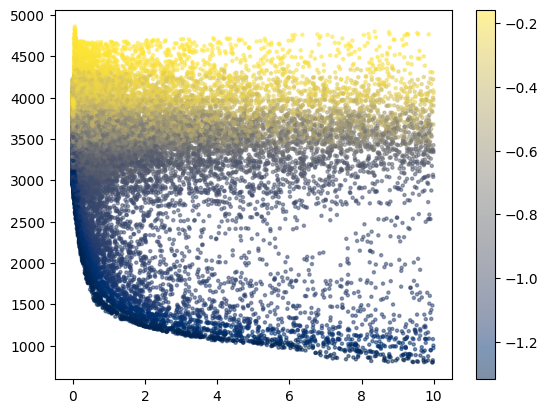

In [17]:
fig, ax=plt.subplots()
c=ax.scatter(mor.age, mor.temperature.values,  c=np.log10(mor.mass),  s=5,alpha=0.5, cmap='cividis')

plt.colorbar(c)

In [18]:
df_roman.shape

(12893, 107)

In [1]:
def make_systems(mods, bfraction):
    
    def create_singles(mods):
        singles = mods['sing_evol'].copy()
        singles['is_binary'] = np.zeros_like(mods['sing_spt'], dtype=bool)
        singles['spt'] = mods['sing_spt']
        singles['prim_spt'] = mods['sing_spt']
        singles['sec_spt'] = np.full(mods['sing_spt'].shape, np.nan)
        
        return singles
    
    def create_binaries(mods):
        binaries = {
            'age': mods['prim_evol']['age'],
            'mass': mods['prim_evol']['mass'] + mods['sec_evol']['mass'],
            'pri_mass': mods['prim_evol']['mass'],
            'sec_mass': mods['sec_evol']['mass'],
            'luminosity': np.log10(10 ** mods['prim_evol']['luminosity'] + 10 ** mods['sec_evol']['luminosity']),
            'spt': np.random.normal(mods['binary_spt'], 0.3),
            'prim_spt': mods['prim_spt'],
            'sec_spt': mods['sec_spt'],
            'prim_luminosity': 10 ** mods['prim_evol']['luminosity'],
            'sec_luminosity': 10 ** mods['sec_evol']['luminosity'],
            'is_binary': np.ones_like(mods['sec_spt'], dtype=bool)
        }

        mask = binaries['spt'] > 20
        teff_func = np.vectorize(lambda spt: spt_to_teff_kirkpatrick(spt)[0] if spt > 20 else spt_to_teff_pecaut(spt))
        binaries['temperature'] = teff_func(binaries['spt'])
        return binaries

    def choose_binaries(binaries, n_draw):
        random_int = np.random.choice(np.arange(len(binaries['spt'])), n_draw)
        return {k: binaries[k][random_int] for k in binaries.keys()}

    singles = create_singles(mods)
    binaries = create_binaries(mods)

    n_draw = int(len(mods['sing_spt']) / (1 - bfraction)) - len(mods['sing_spt'])
    chosen_binaries = choose_binaries(binaries, n_draw)

    res = pd.concat([pd.DataFrame(singles), pd.DataFrame(chosen_binaries)])
    scale, scale_unc, scale_times_model = scale_to_local_lf(res.temperature.values)

    res['scale'] = scale
    res['scale_unc'] = scale_unc
    res['scale_times_model'] = scale_times_model
    return res


In [19]:
#--> create a fast interpolation classs
#--> include/rearrange Roman's models
#--> rerun simulations with metallicities as input